# 1. Data Preprocessing and Splitting

### 1.1 Read the "Data.csv" file

In [11]:
import pandas as pd 

data = pd.read_csv("Data.csv", delimiter=',')
data

,name,dft_gibbs_free_energy_ev,dft_electronic_energy_ev,dft_entropy_ev,dft_enthalpy_ev,hf_gibbs_free_energy_ev,hf_electronic_energy_ev,hf_entropy_ev,hf_enthalpy_ev
0,dimer_001338,-16917.573481,-16925.578752,1.791468,-16915.782013,-16699.004234,-16708.542262,1.732034,-16697.272200
1,dimer_001340,-15834.675653,-15843.326901,1.798428,-15832.877225,-15625.077800,-15635.403855,1.730149,-15623.347651
2,dimer_001341,-16916.895225,-16924.923731,1.759009,-16915.136217,-16698.972462,-16708.490025,1.728173,-16697.244289
3,dimer_001343,-14897.694694,-14905.933900,1.622494,-14896.072200,-14700.613585,-14710.492825,1.568488,-14699.045097
4,dimer_001346,-14897.734585,-14905.936524,1.662438,-14896.072147,-14700.649672,-14710.478436,1.617040,-14699.032632
...,...,...,...,...,...,...,...,...,...
495,dimer_006866,-21012.703301,-21021.225137,1.712411,-21010.990890,-20749.312102,-20759.341495,1.684781,-20747.627320
496,dimer_006867,-21012.822136,-21021.382126,1.678073,-21011.144062,-20749.476476,-20759.553687,1.651282,-20747.825194
497,dimer_006868,-22968.461459,-22975.705901,1.679857,-22966.781601,-22687.402193,-22695.824857,1.667343,-22685.734851
498,dimer_006888,-21011.089783,-21019.404453,1.841686,-21009.248097,-20745.883071,-20755.660873,1.804790,-20744.078281


### 1.2 Define predictors and target

In [12]:
X = data[['hf_gibbs_free_energy_ev', 
          'hf_electronic_energy_ev',
          'hf_entropy_ev', 'hf_enthalpy_ev']]

y = data['dft_enthalpy_ev']

### 1.3 Split dataset into training and testing sets (80/20 split)

In [13]:
#!pip install scikit-learn
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 1.4 Scale data and save scalers

In [14]:
from sklearn.preprocessing import StandardScaler
import joblib

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

joblib.dump(scaler, 'scaler.pkl')

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))
joblib.dump(scaler_y, 'scaler_y.pkl')

['scaler_y.pkl']

# 2. Single Layer Perceptron

### 2.1 Install libraries

In [15]:
#-# !pip install optuna
#-# !pip install tensorflow
#-# !pip install keras

### 2.2 Import libraries

In [16]:
import optuna 
import numpy as np 
import tensorflow as tf 

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1_l2
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

### 2.3 Create "objective" function for optimization

In [17]:
def objective(trial):
    """
    Objective function for Optuna that defines the task for hyperparameter search.

    Parameters:
    - trial (optuna.trial.Trial): Optuna trial object used to suggest hyperparameters.

    Returns:
    - float: Mean MSE value across all folds of cross-validation.
    """
    #-# Define the hyperparameter grid
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop', 'Adagrad'])
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'sigmoid', 'tanh', 'leaky_relu'])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    num_neurons = trial.suggest_int('num_neurons', 5, 200, log=True)
    l1_reg = trial.suggest_float('l1_reg', 1e-8, 100, log=True)
    l2_reg = trial.suggest_float('l2_reg', 1e-8, 100, log=True)

    #-# Create model with current hyperparameters
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),
        tf.keras.layers.Dense(num_neurons, activation=activation_function, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)),
        tf.keras.layers.Dense(1)
    ])

    #-# Define optimizer based on selected option
    optimizer = getattr(tf.keras.optimizers, optimizer_name)(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])

    #-# Initialize KFold cross-validation
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    fold_mses = []

    #-# Perform cross-validation
    for train_index, val_index in kf.split(X_train_scaled):
        X_train_cv, X_val_cv = X_train_scaled[train_index], X_train_scaled[val_index]
        y_train_cv, y_val_cv = y_train_scaled[train_index], y_train_scaled[val_index]

        #-# Apply EarlyTopping technique to prevent overfitting
        early_stopping = EarlyStopping(monitor='val_loss', mode='min', restore_best_weights=True, patience=10, verbose=0)

        #-# Train the model
        model.fit(X_train_cv, y_train_cv, epochs=100, batch_size=32, validation_data=(X_val_cv, y_val_cv), callbacks=[early_stopping], verbose=0)

        #-# Evaluate on validation set
        y_pred_cv = model.predict(X_val_cv)
        mse = mean_squared_error(y_val_cv, y_pred_cv)
        fold_mses.append(mse)

    return np.mean(fold_mses)

### 2.4 Run the optimization

In [18]:
#-# Adjust the number of trials if you'd like to get more precise results 
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2024-11-02 23:29:09,595] A new study created in memory with name: no-name-3b357043-4a05-42a8-a898-3ac151ff2b55


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-11-02 23:29:35,851] Trial 0 finished with value: 0.004717398814846414 and parameters: {'optimizer': 'Adam', 'activation_function': 'leaky_relu', 'learning_rate': 0.0027363811908806468, 'num_neurons': 15, 'l1_reg': 5.269438854586236e-05, 'l2_reg': 3.307101722821736}. Best is trial 0 with value: 0.004717398814846414.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-11-02 23:30:01,207] Trial 1 finished with value: 0.5991268591777745 and parameters: {'optimizer': 'Adam', 'activation_function': 'relu', 'learning_rate': 0.0001295103432306983, 'num_neurons': 6, 'l1_reg': 11.21547005522746, 'l2_reg': 1.7794893717037795e-08}. Best is trial 0 with value: 0.004717398814846414.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-11-02 23:30:26,924] Trial 2 finished with value: 1.0116405243455875 and parameters: {'optimizer': 'Adam', 'activation_function': 'sigmoid', 'learning_rate': 1.0345144945923895e-05, 'num_neurons': 38, 'l1_reg': 0.00011108180022231207, 'l2_reg': 1.5031208195043815e-07}. Best is trial 0 with value: 0.004717398814846414.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-11-02 23:30:49,139] Trial 3 finished with value: 0.0678617732634977 and parameters: {'optimizer': 'Adagrad', 'activation_function': 'tanh', 'learning_rate': 0.006429412117796637, 'num_neurons': 9, 'l1_reg': 0.2653558288250482, 'l2_reg': 0.0009001509586022593}. Best is trial 0 with value: 0.004717398814846414.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-11-02 23:31:11,275] Trial 4 finished with value: 1.9532643985158777 and parameters: {'optimizer': 'Adagrad', 'activation_function': 'leaky_relu', 'learning_rate': 2.6336877074613105e-05, 'num_neurons': 7, 'l1_reg': 0.0039438764661579705, 'l2_reg': 0.0013551690236666815}. Best is trial 0 with value: 0.004717398814846414.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-11-02 23:31:33,237] Trial 5 finished with value: 1.2062268024823617 and parameters: {'optimizer': 'SGD', 'activation_function': 'leaky_relu', 'learning_rate': 1.0138322413956007e-05, 'num_neurons': 67, 'l1_reg': 2.1560751921437286e-06, 'l2_reg': 1.3292174193372714}. Best is trial 0 with value: 0.004717398814846414.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-11-02 23:31:56,880] Trial 6 finished with value: 0.0017534906556113722 and parameters: {'optimizer': 'Adagrad', 'activation_function': 'leaky_relu', 'learning_rate': 0.0024951506720326515, 'num_neurons': 31, 'l1_reg': 1.3654201992424719e-08, 'l2_reg': 5.852565174402654e-07}. Best is trial 6 with value: 0.0017534906556113722.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-11-02 23:32:19,822] Trial 7 finished with value: 0.26252570101353473 and parameters: {'optimizer': 'SGD', 'activation_function': 'leaky_relu', 'learning_rate': 0.00013601592850840283, 'num_neurons': 62, 'l1_reg': 2.38264511345659e-05, 'l2_reg': 2.9840591263587015}. Best is trial 6 with value: 0.0017534906556113722.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-11-02 23:32:44,520] Trial 8 finished with value: 1.672551906185074 and parameters: {'optimizer': 'Adam', 'activation_function': 'relu', 'learning_rate': 1.0644192620770398e-05, 'num_neurons': 45, 'l1_reg': 22.427585270049423, 'l2_reg': 1.3266150113066648}. Best is trial 6 with value: 0.0017534906556113722.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-11-02 23:32:54,014] Trial 9 finished with value: 1.002135678513218 and parameters: {'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'learning_rate': 0.0019722922172099905, 'num_neurons': 8, 'l1_reg': 19.087632892894845, 'l2_reg': 0.29629860376729034}. Best is trial 6 with value: 0.0017534906556113722.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-11-02 23:33:14,668] Trial 10 finished with value: 0.0025649771744828717 and parameters: {'optimizer': 'Adagrad', 'activation_function': 'tanh', 'learning_rate': 0.0008813819480050352, 'num_neurons': 166, 'l1_reg': 3.7910269044509606e-08, 'l2_reg': 3.803708508122337e-06}. Best is trial 6 with value: 0.0017534906556113722.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-11-02 23:33:34,729] Trial 11 finished with value: 0.0015987873180940105 and parameters: {'optimizer': 'Adagrad', 'activation_function': 'tanh', 'learning_rate': 0.0007680175897327496, 'num_neurons': 176, 'l1_reg': 2.6239648665244588e-08, 'l2_reg': 3.758266315350982e-06}. Best is trial 11 with value: 0.0015987873180940105.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-11-02 23:33:53,470] Trial 12 finished with value: 0.0017873720462113867 and parameters: {'optimizer': 'Adagrad', 'activation_function': 'tanh', 'learning_rate': 0.0005916052182391653, 'num_neurons': 179, 'l1_reg': 1.5162689038243595e-08, 'l2_reg': 7.953905506271185e-06}. Best is trial 11 with value: 0.0015987873180940105.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


[I 2024-11-02 23:34:20,352] Trial 13 finished with value: 0.0027416580092618457 and parameters: {'optimizer': 'Adagrad', 'activation_function': 'tanh', 'learning_rate': 0.005587438782193253, 'num_neurons': 17, 'l1_reg': 1.6257908590904244e-07, 'l2_reg': 1.7094223853354123e-05}. Best is trial 11 with value: 0.0015987873180940105.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-11-02 23:34:33,844] Trial 14 finished with value: 4.147192236506643e-06 and parameters: {'optimizer': 'RMSprop', 'activation_function': 'leaky_relu', 'learning_rate': 0.0002420761192262763, 'num_neurons': 113, 'l1_reg': 6.818561531907929e-07, 'l2_reg': 6.29445077067131e-07}. Best is trial 14 with value: 4.147192236506643e-06.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-11-02 23:35:00,168] Trial 15 finished with value: 9.751222035061695e-05 and parameters: {'optimizer': 'RMSprop', 'activation_function': 'tanh', 'learning_rate': 0.00020977189214514761, 'num_neurons': 86, 'l1_reg': 1.2236831976607594e-06, 'l2_reg': 0.0004023417903055834}. Best is trial 14 with value: 4.147192236506643e-06.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-11-02 23:35:22,760] Trial 16 finished with value: 0.00039546545379548595 and parameters: {'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'learning_rate': 0.00013654403708866664, 'num_neurons': 98, 'l1_reg': 1.2898001383663068e-06, 'l2_reg': 0.0005790239683742787}. Best is trial 14 with value: 4.147192236506643e-06.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-11-02 23:35:46,520] Trial 17 finished with value: 0.0008616017439887072 and parameters: {'optimizer': 'RMSprop', 'activation_function': 'relu', 'learning_rate': 5.463606064806021e-05, 'num_neurons': 105, 'l1_reg': 0.0010375073844956784, 'l2_reg': 0.01695683407364035}. Best is trial 14 with value: 4.147192236506643e-06.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-11-02 23:36:03,513] Trial 18 finished with value: 7.854027063040775e-05 and parameters: {'optimizer': 'RMSprop', 'activation_function': 'tanh', 'learning_rate': 0.0003474392091430759, 'num_neurons': 102, 'l1_reg': 1.2956786559930685e-06, 'l2_reg': 4.574838526741385e-05}. Best is trial 14 with value: 4.147192236506643e-06.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-11-02 23:36:25,369] Trial 19 finished with value: 0.5239765032549198 and parameters: {'optimizer': 'RMSprop', 'activation_function': 'leaky_relu', 'learning_rate': 0.00035335288977360834, 'num_neurons': 121, 'l1_reg': 0.017385186710079582, 'l2_reg': 98.8821376490876}. Best is trial 14 with value: 4.147192236506643e-06.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-11-02 23:36:50,178] Trial 20 finished with value: 0.0022393633064697097 and parameters: {'optimizer': 'RMSprop', 'activation_function': 'tanh', 'learning_rate': 7.375171064561586e-05, 'num_neurons': 56, 'l1_reg': 9.167206824367237e-06, 'l2_reg': 5.522980749258298e-05}. Best is trial 14 with value: 4.147192236506643e-06.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-11-02 23:37:13,445] Trial 21 finished with value: 9.34083399279686e-05 and parameters: {'optimizer': 'RMSprop', 'activation_function': 'tanh', 'learning_rate': 0.0002796202314930994, 'num_neurons': 82, 'l1_reg': 4.822373441464721e-07, 'l2_reg': 0.000163496792318378}. Best is trial 14 with value: 4.147192236506643e-06.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-11-02 23:37:31,654] Trial 22 finished with value: 4.961051598030213e-05 and parameters: {'optimizer': 'RMSprop', 'activation_function': 'tanh', 'learning_rate': 0.0003422890809771344, 'num_neurons': 129, 'l1_reg': 2.471361797315979e-07, 'l2_reg': 3.064334342891698e-07}. Best is trial 14 with value: 4.147192236506643e-06.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-11-02 23:37:43,372] Trial 23 finished with value: 6.343425589845546e-05 and parameters: {'optimizer': 'RMSprop', 'activation_function': 'tanh', 'learning_rate': 0.00047954864009078755, 'num_neurons': 136, 'l1_reg': 2.6055308724345147e-07, 'l2_reg': 3.063034559048929e-07}. Best is trial 14 with value: 4.147192236506643e-06.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-11-02 23:37:51,294] Trial 24 finished with value: 0.00035995054035703526 and parameters: {'optimizer': 'RMSprop', 'activation_function': 'tanh', 'learning_rate': 0.0010254855677010997, 'num_neurons': 154, 'l1_reg': 1.5063092492680972e-07, 'l2_reg': 1.3689911753061744e-08}. Best is trial 14 with value: 4.147192236506643e-06.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-11-02 23:38:13,884] Trial 25 finished with value: 1.2741658135842025e-05 and parameters: {'optimizer': 'RMSprop', 'activation_function': 'leaky_relu', 'learning_rate': 0.00043077532863014, 'num_neurons': 133, 'l1_reg': 0.0002425350416707156, 'l2_reg': 6.338847287384113e-07}. Best is trial 14 with value: 4.147192236506643e-06.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-11-02 23:38:35,029] Trial 26 finished with value: 0.009025057895588195 and parameters: {'optimizer': 'SGD', 'activation_function': 'leaky_relu', 'learning_rate': 0.001249613016191062, 'num_neurons': 22, 'l1_reg': 0.0002639220038932449, 'l2_reg': 1.049590028934048e-07}. Best is trial 14 with value: 4.147192236506643e-06.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-11-02 23:38:55,312] Trial 27 finished with value: 4.047780039176595e-05 and parameters: {'optimizer': 'RMSprop', 'activation_function': 'leaky_relu', 'learning_rate': 7.67718610050237e-05, 'num_neurons': 75, 'l1_reg': 7.342823848479185e-06, 'l2_reg': 1.4899609087221453e-06}. Best is trial 14 with value: 4.147192236506643e-06.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-11-02 23:39:17,009] Trial 28 finished with value: 0.09764381203554763 and parameters: {'optimizer': 'RMSprop', 'activation_function': 'leaky_relu', 'learning_rate': 4.537867366339045e-05, 'num_neurons': 46, 'l1_reg': 7.652496763206807e-06, 'l2_reg': 1.054700700129605e-06}. Best is trial 14 with value: 4.147192236506643e-06.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-11-02 23:39:38,776] Trial 29 finished with value: 0.018375244879796346 and parameters: {'optimizer': 'RMSprop', 'activation_function': 'leaky_relu', 'learning_rate': 2.7547145405696797e-05, 'num_neurons': 70, 'l1_reg': 0.053807611364117144, 'l2_reg': 7.195567511535804e-08}. Best is trial 14 with value: 4.147192236506643e-06.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-11-02 23:40:00,527] Trial 30 finished with value: 0.012593666314594102 and parameters: {'optimizer': 'RMSprop', 'activation_function': 'leaky_relu', 'learning_rate': 8.778379259549188e-05, 'num_neurons': 11, 'l1_reg': 0.00039702675085390415, 'l2_reg': 1.6823039391432629e-06}. Best is trial 14 with value: 4.147192236506643e-06.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-11-02 23:40:23,511] Trial 31 finished with value: 2.221684143808076e-06 and parameters: {'optimizer': 'RMSprop', 'activation_function': 'leaky_relu', 'learning_rate': 0.0002056507486431957, 'num_neurons': 199, 'l1_reg': 2.3245876147791472e-05, 'l2_reg': 4.371907855050314e-08}. Best is trial 31 with value: 2.221684143808076e-06.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-11-02 23:40:45,953] Trial 32 finished with value: 2.9964740567884004e-06 and parameters: {'optimizer': 'RMSprop', 'activation_function': 'leaky_relu', 'learning_rate': 0.00021823563972620896, 'num_neurons': 128, 'l1_reg': 3.370796014435516e-05, 'l2_reg': 4.6343270244486e-08}. Best is trial 31 with value: 2.221684143808076e-06.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-11-02 23:41:08,896] Trial 33 finished with value: 1.0672855751772748e-05 and parameters: {'optimizer': 'RMSprop', 'activation_function': 'leaky_relu', 'learning_rate': 0.0002016891960761046, 'num_neurons': 197, 'l1_reg': 0.00010325490268989271, 'l2_reg': 5.662119746236469e-08}. Best is trial 31 with value: 2.221684143808076e-06.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-11-02 23:41:32,014] Trial 34 finished with value: 9.493588671855908e-05 and parameters: {'optimizer': 'Adam', 'activation_function': 'leaky_relu', 'learning_rate': 0.00020617740053594527, 'num_neurons': 193, 'l1_reg': 3.5087242360140676e-05, 'l2_reg': 3.4857893536470596e-08}. Best is trial 31 with value: 2.221684143808076e-06.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


[I 2024-11-02 23:41:58,813] Trial 35 finished with value: 0.2769549753072153 and parameters: {'optimizer': 'Adam', 'activation_function': 'leaky_relu', 'learning_rate': 0.0001982548015047248, 'num_neurons': 5, 'l1_reg': 7.606207214085087e-05, 'l2_reg': 1.713519021163168e-08}. Best is trial 31 with value: 2.221684143808076e-06.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-11-02 23:42:12,991] Trial 36 finished with value: 0.9981196994734526 and parameters: {'optimizer': 'SGD', 'activation_function': 'leaky_relu', 'learning_rate': 0.00011517711811854988, 'num_neurons': 200, 'l1_reg': 1.9085675260094972, 'l2_reg': 4.359481822063348e-08}. Best is trial 31 with value: 2.221684143808076e-06.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-11-02 23:42:38,823] Trial 37 finished with value: 0.0002951497974192629 and parameters: {'optimizer': 'RMSprop', 'activation_function': 'relu', 'learning_rate': 0.00019636215353561115, 'num_neurons': 152, 'l1_reg': 0.0025489175936635345, 'l2_reg': 1.4708293268157174e-07}. Best is trial 31 with value: 2.221684143808076e-06.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-11-02 23:43:02,316] Trial 38 finished with value: 2.2094041404645953e-05 and parameters: {'optimizer': 'RMSprop', 'activation_function': 'leaky_relu', 'learning_rate': 0.00012272996037985246, 'num_neurons': 114, 'l1_reg': 1.8457523604238834e-05, 'l2_reg': 0.005826293575200298}. Best is trial 31 with value: 2.221684143808076e-06.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-11-02 23:43:24,721] Trial 39 finished with value: 0.0011741325353908367 and parameters: {'optimizer': 'Adam', 'activation_function': 'sigmoid', 'learning_rate': 0.0015252807910038104, 'num_neurons': 33, 'l1_reg': 9.744606611439139e-05, 'l2_reg': 1.659490359552189e-08}. Best is trial 31 with value: 2.221684143808076e-06.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-11-02 23:43:46,979] Trial 40 finished with value: 0.0015012258097859335 and parameters: {'optimizer': 'SGD', 'activation_function': 'leaky_relu', 'learning_rate': 0.0006206302973119969, 'num_neurons': 92, 'l1_reg': 0.013026551697310328, 'l2_reg': 1.0035747404138097e-08}. Best is trial 31 with value: 2.221684143808076e-06.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-11-02 23:44:09,330] Trial 41 finished with value: 1.5955763391130514e-05 and parameters: {'optimizer': 'RMSprop', 'activation_function': 'leaky_relu', 'learning_rate': 0.00045502274699585875, 'num_neurons': 130, 'l1_reg': 0.000291917101039295, 'l2_reg': 3.946530465560557e-07}. Best is trial 31 with value: 2.221684143808076e-06.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-11-02 23:44:32,230] Trial 42 finished with value: 4.752748452717192e-05 and parameters: {'optimizer': 'RMSprop', 'activation_function': 'leaky_relu', 'learning_rate': 0.0002675392139960867, 'num_neurons': 147, 'l1_reg': 0.0011580216246475014, 'l2_reg': 7.709595533990081e-08}. Best is trial 31 with value: 2.221684143808076e-06.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-11-02 23:44:41,797] Trial 43 finished with value: 2.739471236542565e-06 and parameters: {'optimizer': 'RMSprop', 'activation_function': 'leaky_relu', 'learning_rate': 0.00018051774188161966, 'num_neurons': 160, 'l1_reg': 3.2055965508839355e-06, 'l2_reg': 2.799593781758352e-07}. Best is trial 31 with value: 2.221684143808076e-06.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-11-02 23:44:52,216] Trial 44 finished with value: 2.34640071627106e-06 and parameters: {'optimizer': 'RMSprop', 'activation_function': 'leaky_relu', 'learning_rate': 0.00016601456216957215, 'num_neurons': 157, 'l1_reg': 5.070202725000012e-06, 'l2_reg': 3.561057398967906e-08}. Best is trial 31 with value: 2.221684143808076e-06.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-11-02 23:45:15,181] Trial 45 finished with value: 0.059623679506330025 and parameters: {'optimizer': 'RMSprop', 'activation_function': 'leaky_relu', 'learning_rate': 4.575430541525768e-05, 'num_neurons': 55, 'l1_reg': 5.9547297334151383e-08, 'l2_reg': 1.9988021383852232e-07}. Best is trial 31 with value: 2.221684143808076e-06.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-11-02 23:45:27,146] Trial 46 finished with value: 3.859087307642939e-06 and parameters: {'optimizer': 'RMSprop', 'activation_function': 'relu', 'learning_rate': 0.00015050977623171457, 'num_neurons': 166, 'l1_reg': 3.049581024005117e-06, 'l2_reg': 5.250094105953761e-06}. Best is trial 31 with value: 2.221684143808076e-06.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-11-02 23:45:43,422] Trial 47 finished with value: 0.0003227715082283218 and parameters: {'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'learning_rate': 0.00014400106508918894, 'num_neurons': 149, 'l1_reg': 3.7308060979034347e-06, 'l2_reg': 3.273903218500671e-06}. Best is trial 31 with value: 2.221684143808076e-06.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-11-02 23:46:10,545] Trial 48 finished with value: 0.7528012443843215 and parameters: {'optimizer': 'Adagrad', 'activation_function': 'relu', 'learning_rate': 2.8786776406338162e-05, 'num_neurons': 182, 'l1_reg': 3.0551473117717232e-06, 'l2_reg': 4.104649989770975e-08}. Best is trial 31 with value: 2.221684143808076e-06.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-11-02 23:46:33,660] Trial 49 finished with value: 0.6837728386661511 and parameters: {'optimizer': 'Adam', 'activation_function': 'relu', 'learning_rate': 9.762231425816316e-05, 'num_neurons': 165, 'l1_reg': 82.5145355580623, 'l2_reg': 1.0679051227089345e-05}. Best is trial 31 with value: 2.221684143808076e-06.


### 2.5 Print and save the best hyperparameters

In [20]:
best_trial = study.best_trial
print(f'Best trial value: {best_trial.value}')
print(f'Best hyperparameters: {best_trial.params}')

Best trial value: 2.221684143808076e-06
Best hyperparameters: {'optimizer': 'RMSprop', 'activation_function': 'leaky_relu', 'learning_rate': 0.0002056507486431957, 'num_neurons': 199, 'l1_reg': 2.3245876147791472e-05, 'l2_reg': 4.371907855050314e-08}


In [21]:
#-# Save the optimization results
with open('optimization_results.txt', 'w') as f:
    f.write(f'Best trial value: {best_trial.value}\n')
    f.write(f'Best hyperparameters: {best_trial.params}\n')

    f.write('\nAll trial results:\n')
    for trial in study.trials:
        f.write(f'Trial {trial.number}: Value={trial.value}, Params={trial.params}\n')

### 2.6 Retrieve the best hyperparameters 

In [43]:
best_params = study.best_params

### 2.7 Build and train the final model with the best hyperparameters

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(best_params['num_neurons'], activation=best_params['activation_function'], kernel_regularizer=l1_l2(l1=best_params['l1_reg'], l2=best_params['l2_reg'])),
    tf.keras.layers.Dense(1)
])

In [45]:
#-# Select the best optimizer
optimizer = getattr(tf.keras.optimizers, best_params['optimizer'])(learning_rate=best_params['learning_rate'])

#-# Apply EarlyTopping technique to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', mode='min', restore_best_weights=True, patience=10, verbose=0)

#-# Compile the model with the best optimizer
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])

### 2.8 Train the model using the best hyperparameters 

In [ ]:
history = model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=1)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7558 - mse: 0.7542 - val_loss: 0.6826 - val_mse: 0.6810
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5100 - mse: 0.5084 - val_loss: 0.5102 - val_mse: 0.5086
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3759 - mse: 0.3743 - val_loss: 0.3712 - val_mse: 0.3696
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2652 - mse: 0.2636 - val_loss: 0.2688 - val_mse: 0.2671
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1851 - mse: 0.1835 - val_loss: 0.1847 - val_mse: 0.1830
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1073 - mse: 0.1057 - val_loss: 0.1177 - val_mse: 0.1161
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0682 - mse: 0.0665 - val_loss: 0.0729 - val_mse: 0.0713
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0408 - mse: 0.0392 - val_loss: 0.0405 - val_mse: 0.0388
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.02

### 2.9 Save training and validation loss to a text file 

In [47]:
with open('training_validation_loss.txt', 'w') as f:
    f.write("Epoch\tTraining Loss\tValidation Loss\n")
    for epoch, (train_loss, val_loss) in enumerate(zip(history.history['loss'], history.history['val_loss']), 1):
        f.write(f"{epoch}\t{train_loss:.4f}\t{val_loss:.4f}\n")
print("Training and validation loss curves saved to ./training_validation_loss.txt")

Training and validation loss curves saved to ./training_validation_loss.txt


### 2.10 Plot training and validtion curves

Plot saved to ./training_validation_loss.png


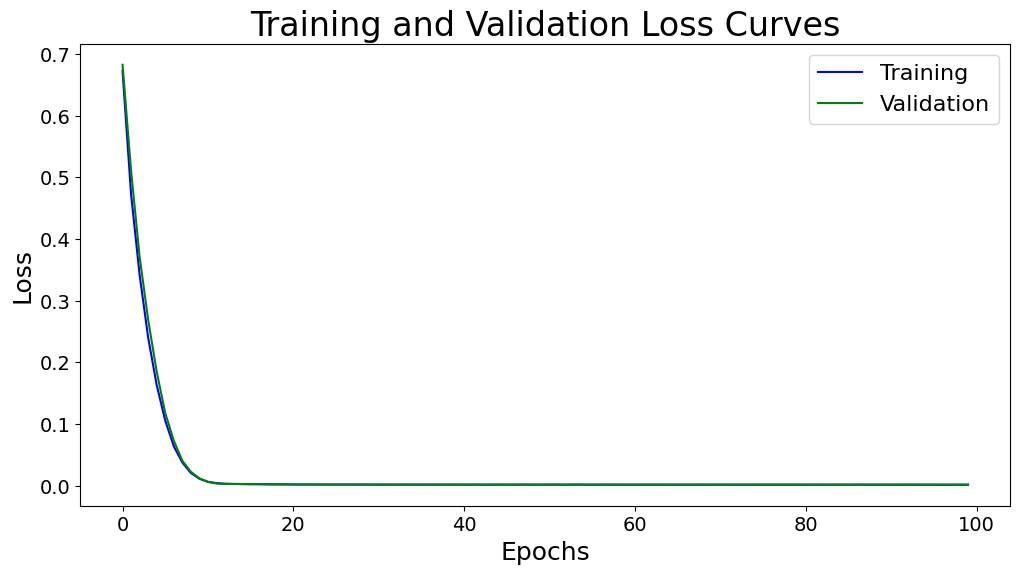

In [48]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training', color='blue')
plt.plot(history.history['val_loss'], label='Validation', color='green')

plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.title('Training and Validation Loss Curves', fontsize=24)
plt.legend(fontsize=16)
plt.grid(False)

plt.savefig('training_validation_loss.png', bbox_inches='tight')
print("Plot saved to ./training_validation_loss.png")

### 2.10 Save the model

In [49]:
model.save('slp_model.keras')
print("Model saved to ./slp_model.keras")

Model saved to ./slp_model.keras


### 2.11 Predict values on test data 

In [50]:
y_pred = model.predict(X_test_scaled).flatten() 

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


### 2.12 Inverse scaled values

In [59]:
y_pred_scaled_reshaped = y_pred.reshape(-1, 1)
y_test_scaled_reshaped = y_test_scaled.reshape(-1, 1)

y_pred_inverse = scaler_y.inverse_transform(y_pred_scaled_reshaped).flatten()
y_test_inverse = scaler_y.inverse_transform(y_test_scaled_reshaped).flatten() 

### 2.13 Calculate metrics

In [60]:
from sklearn.metrics import mean_absolute_error, r2_score

mse = mean_squared_error(y_test_inverse, y_pred_inverse)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
r2 = r2_score(y_test_inverse, y_pred_inverse)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R^2 Score: {r2:.4f}")

Mean Squared Error (MSE): 16.2898
Root Mean Squared Error (RMSE): 4.0361
Mean Absolute Error (MAE): 2.8663
R^2 Score: 1.0000


### 2.14 Visualize the results 

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test_inverse, y_pred_inverse, color='blue', alpha=0.6)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.title("Enthalpy, eV", fontsize=22)
plt.grid(False)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#-# Add metrics to the plot
metrics_text = f"MSE: {mse:.4f}\nRMSE: {rmse:.4f}\nMAE: {mae:.4f}\n$R^2$: {r2:.4f}"
plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes, fontsize=16, 
         verticalalignment='top', 
         bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='lightgreen'))

plt.show()

#-# Save actual and predicted values to a CSV file
results = pd.DataFrame({'Actual': y_test_inverse, 'Predicted': y_pred_inverse})
results.to_csv('SLP(Act_vs_Pred).csv', index=False)